# Data Context

The dataset used in this study originates from the SemEval 2025 shared task on multilingual characterisation and extraction of narratives from online news. It comprises around 1,900 news articles equally split across five languages (Bulgarian, English, Hindi, Portuguese, and Russian) collected between 2022 and mid-2024. The articles cover two domains: (1) the Ukraine-Russia war and (2) Climate Change, with a focus on alternative news outlets, many of which were identified by fact-checkers as potential sources of disinformation. The articles are expert-annotated for two sub-tasks: entity framing and narrative classification. Both are multi-label, multi-class classification tasks. The golden truth labels are in the form of fine-grained, two-level taxonomies.

The articles presented here are translations of the originals. The GPT-4o model was used in the machine translation pipeline and outperformed other explored alternatives, such as NLLB-200, in terms of preserving nuance and structure. The approach is in line with other similar studies in this field.

The dateset has been prepared by the organisers of the Semeveval 2025 shared task on propaganda detection. More information about it can be found [here](https://propaganda.math.unipd.it/semeval2025task10/).

# Data Description

This study investigates robust model performance under distribution shifts, focusing on two forms of divergence: label shift and input shift. The dataset comprises English-translated news articles across two domains—Ukraine-Russia War (UA) and Climate Change (CC)—annotated for two persuasion detection tasks: entity framing and narrative classification.

For entity framing, span-level subrole annotations (e.g., Victim, Corrupt, Guardian) are mapped to high-level roles (Protagonist, Antagonist, Innocent) using the official taxonomy. Narrative classification is performed at the article level, with hierarchical labels comprising domain, main narrative (e.g., Discrediting Ukraine, Downplaying Climate Change), and subnarrative (e.g., Ukraine is a puppet of the West). In both tasks, label frequency analyses reveal substantial label imbalance and domain-specific skew—for instance, Antagonist roles and anti-Ukraine narratives dominate UA data, while CC data is skewed toward policy criticism and climate scepticism. These trends are visualised in label distribution plots and validated through Chi-squared tests, confirming statistically significant label distribution shifts across domains (p < 0.001).

To assess input-level divergence, PCA and t-SNE were applied to sentence-level DeBERTa embeddings of full articles (see Figure 5). These projections reveal clear domain separation in embedding space, indicating non-trivial input shift.

The exploratory analysis confirms the presence of substantial input and label distribution shifts between the Ukraine-Russia War (UA) and Climate Change (CC) domains—both critical challenges to model generalisation. Statistically significant label divergence (p < 0.001) and strong domain separability in PCA and t-SNE visualisations indicate that models trained in one domain are likely to perform suboptimally in the other without adaptation. These findings reinforce the thesis’ core hypothesis: that multi-task learning (MTL) has the potential to mitigate performance degradation by learning shared linguistic representations across persuasion tasks, thereby enhancing robustness under shift. 

Furthermore, the domain imbalance—manifested in the under-representation of CC articles—poses a risk of bias towards UA-specific patterns. To address this, the inclusion of the Coan et al. dataset on contrarian climate claims offers a solution for domain-aware data augmentation [1]. This additional resource could improve the diversity and representativeness of CC data, thereby reducing skew and improving the model’s ability to generalise across both narrative and framing tasks. These insights not only guide architectural decisions (e.g., domain-aware MTL, stratified sampling) but also provide a rationale for incorporating external corpora into future training regimes.

[1] Travis G. Coan, Constantine Boussalis, John Cook, and Mirjam O. Nanko. 2021. Computer-assisted classification of contrarian claims about climate change. Sci Rep 11, 1 (November 2021), 22320. https://doi.org/10.1038/s41598-021-01714-4




# Load Libraries & Data

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import jensenshannon, cosine
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaV2Tokenizer
from transformers import AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import gc
from tqdm import tqdm
import sentencepiece
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
train_all_articles = pd.read_csv('train-all-articles.csv')
train_S1_labels = pd.read_csv('train-S1-labels.csv')
train_S2_labels = pd.read_csv('train-S2-labels.csv')

## General Summary

In [11]:
train_all_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Filename         1782 non-null   object
 1   Language         1782 non-null   object
 2   Translated_Text  1782 non-null   object
 3   Domain           1782 non-null   object
dtypes: object(4)
memory usage: 55.8+ KB


In [13]:
train_all_articles.head()

,Filename,Language,Translated_Text,Domain
0,EN_UA_104876.txt,EN,Putin honours army unit blamed for Bucha massa...,UA
1,EN_UA_011260.txt,EN,Russia has a clear plan to resolve the conflic...,UA
2,EN_UA_101067.txt,EN,"First war of TikTok era sees tragedy, humor an...",UA
3,EN_UA_300048.txt,EN,Ukraine Bombed Diesel Tanks Near A Nuclear Pla...,UA
4,EN_CC_100047.txt,EN,"Biden Has Omnibus Bill, Packed With Climate Ch...",CC


In [15]:
train_S1_labels.head()

,Filename,Entity,Start,End,Label,Language
0,EN_CC_100013.txt,Bill Gates,93,102,"Antagonist, Deceiver, Corrupt",EN
1,EN_CC_100013.txt,BBC,1860,1862,"Antagonist, Deceiver",EN
2,EN_CC_100013.txt,Jeffrey Epstein,2005,2019,"Antagonist, Corrupt",EN
3,EN_UA_300009.txt,Fail Alsynov,176,187,"Protagonist, Rebel, Martyr",EN
4,EN_UA_300009.txt,Bashkir people,1616,1629,"Innocent, Victim",EN


In [17]:
train_S2_labels.head()

,Filename,Narrative,Subnarrative,Language
0,BG_670.txt,URW: Blaming the war on others rather than the...,URW: Blaming the war on others rather than the...,BG
1,A7_URW_BG_4793.txt,URW: Discrediting Ukraine,URW: Discrediting Ukraine: Situation in Ukrain...,BG
2,BG_3245.txt,"URW: Discrediting the West, Diplomacy;URW: Dis...","URW: Discrediting the West, Diplomacy: The Wes...",BG
3,A9_BG_5190.txt,"URW: Discrediting the West, Diplomacy;URW: Dis...","URW: Discrediting the West, Diplomacy: Other;U...",BG
4,A9_BG_3379.txt,"URW: Discrediting the West, Diplomacy;URW: Pra...","URW: Discrediting the West, Diplomacy: Other;U...",BG


## Word Clouds

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

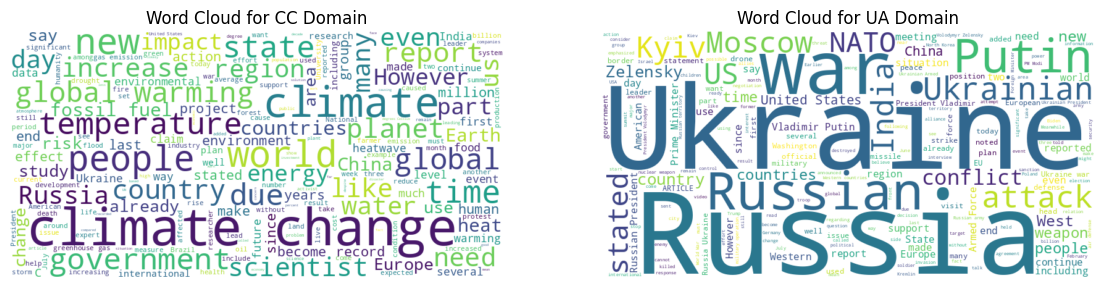

In [21]:
cc_text = " ".join(train_all_articles[train_all_articles["Domain"] == "CC"]["Translated_Text"].dropna())
ua_text = " ".join(train_all_articles[train_all_articles["Domain"] == "UA"]["Translated_Text"].dropna())

# Enhance stopwords list by adding domain-specific or project-specific terms to remove
custom_stopwords = {"said", "may", "also", "one", "would", "be", "will", "could", "year", "according", "U"}

stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('english')).union(custom_stopwords)

# Generate word clouds with the updated stopwords list
wordcloud_cc = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(cc_text)
wordcloud_ua = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(ua_text)

# Display the enhanced word clouds
plt.figure(figsize=(14, 6))

# CC Domain
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for CC Domain")

# UA Domain
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ua, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for UA Domain")

plt.show()

## Analysis 1: Class Imbalance

### Entity Framing

/tmp/ipykernel_278/3037559701.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=main_counts.values, y=main_counts.index, palette='Set2')


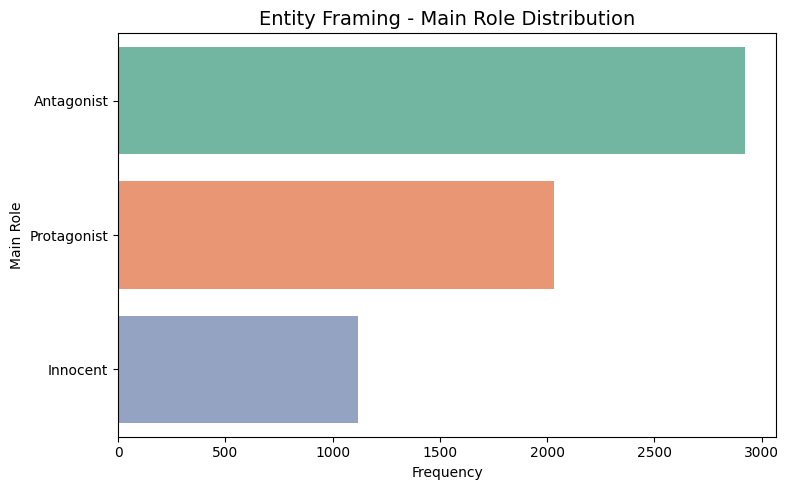

/tmp/ipykernel_278/3037559701.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_counts.values, y=sub_counts.index, palette='Set3')


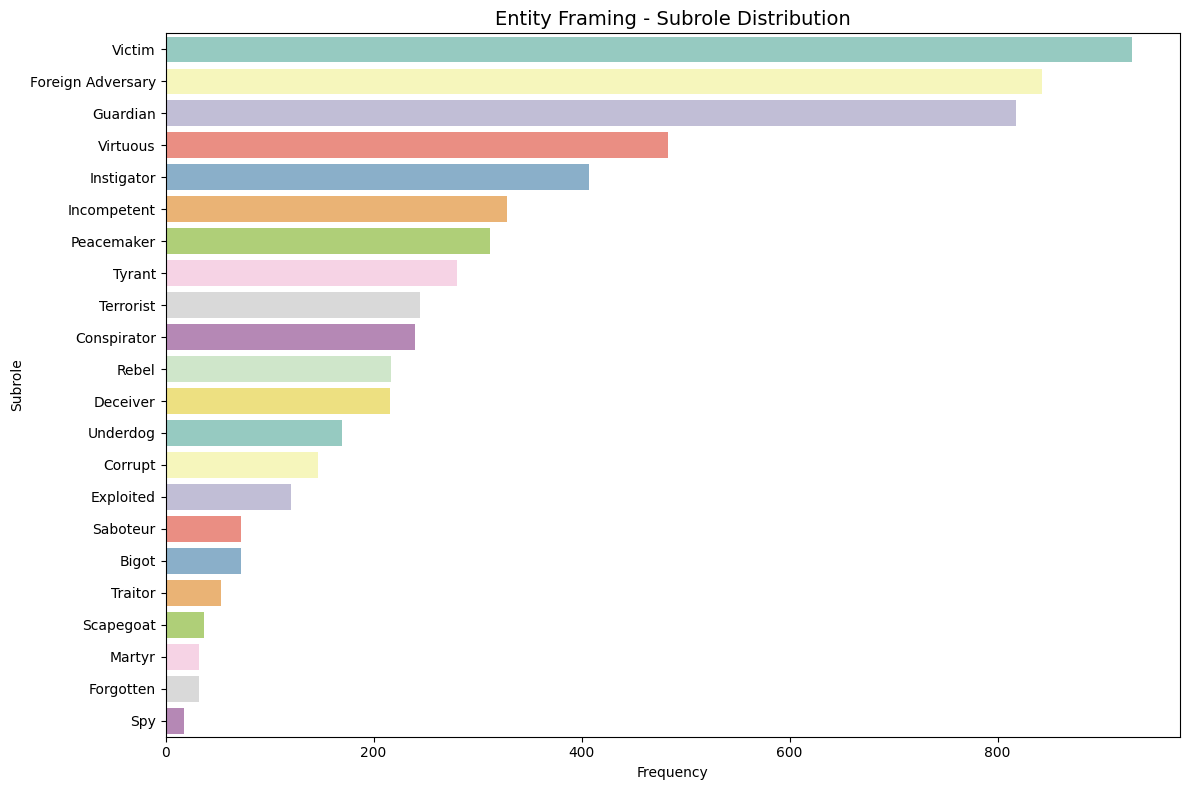

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Define taxonomy mapping: Subrole → Main Role
taxonomy = {
    "Guardian": "Protagonist", "Martyr": "Protagonist", "Peacemaker": "Protagonist",
    "Rebel": "Protagonist", "Underdog": "Protagonist", "Virtuous": "Protagonist",
    "Instigator": "Antagonist", "Conspirator": "Antagonist", "Tyrant": "Antagonist",
    "Foreign Adversary": "Antagonist", "Traitor": "Antagonist", "Spy": "Antagonist",
    "Saboteur": "Antagonist", "Corrupt": "Antagonist", "Incompetent": "Antagonist",
    "Terrorist": "Antagonist", "Deceiver": "Antagonist", "Bigot": "Antagonist",
    "Forgotten": "Innocent", "Exploited": "Innocent", "Victim": "Innocent",
    "Scapegoat": "Innocent"
}

# Load and clean data
df = pd.read_csv("train-S1-labels.csv")
df = df[df['Label'].notna()].copy()
df['Label'] = df['Label'].astype(str).str.split(',\s*', regex=True)
df = df.explode('Label')
df['Label'] = df['Label'].str.strip().str.title()

# Filter to only valid subroles in taxonomy
df = df[df['Label'].isin(taxonomy.keys())]

# Create new column for main role
df['MainRole'] = df['Label'].map(taxonomy)

# Count frequencies
main_counts = df['MainRole'].value_counts()
sub_counts = df['Label'].value_counts()

# --- Plot Main Role Distribution ---
plt.figure(figsize=(8, 5))
sns.barplot(x=main_counts.values, y=main_counts.index, palette='Set2')
plt.title("Entity Framing - Main Role Distribution", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Main Role")
plt.tight_layout()
plt.show()

# --- Plot Subrole Distribution ---
plt.figure(figsize=(12, 8))
sns.barplot(x=sub_counts.values, y=sub_counts.index, palette='Set3')
plt.title("Entity Framing - Subrole Distribution", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Subrole")
plt.tight_layout()
plt.show()


/tmp/ipykernel_278/2777682271.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=main_counts.values, y=main_counts.index, palette="magma")


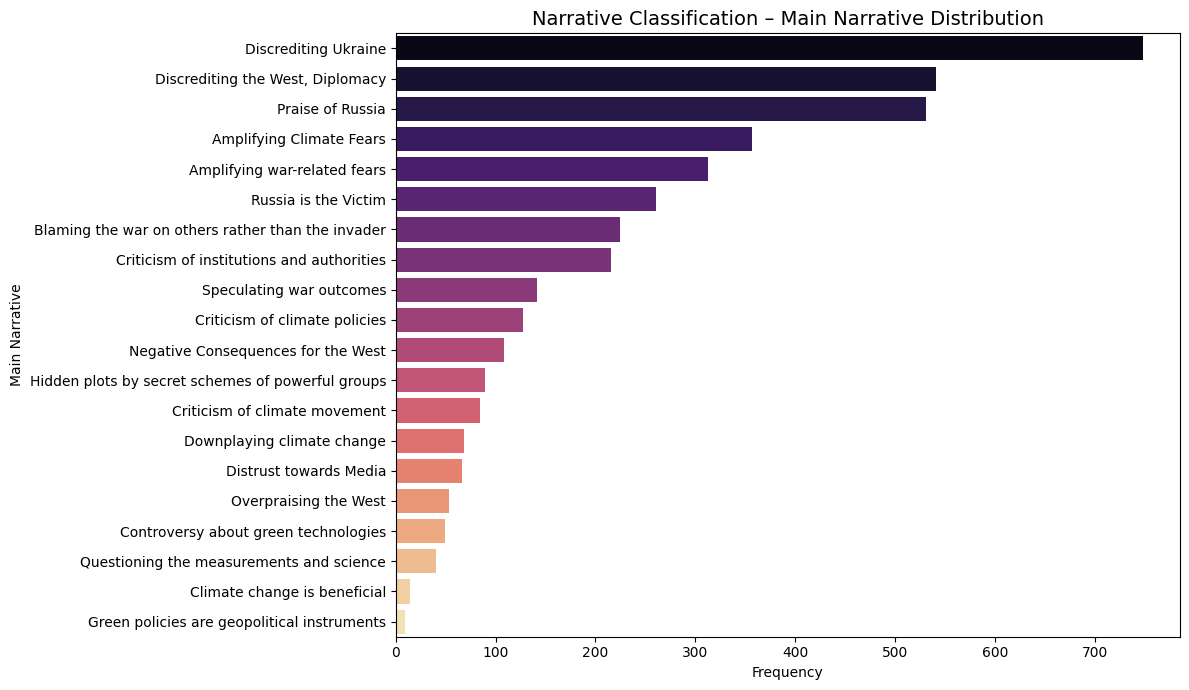

/tmp/ipykernel_278/2777682271.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_counts.values, y=sub_counts.index, palette="viridis")


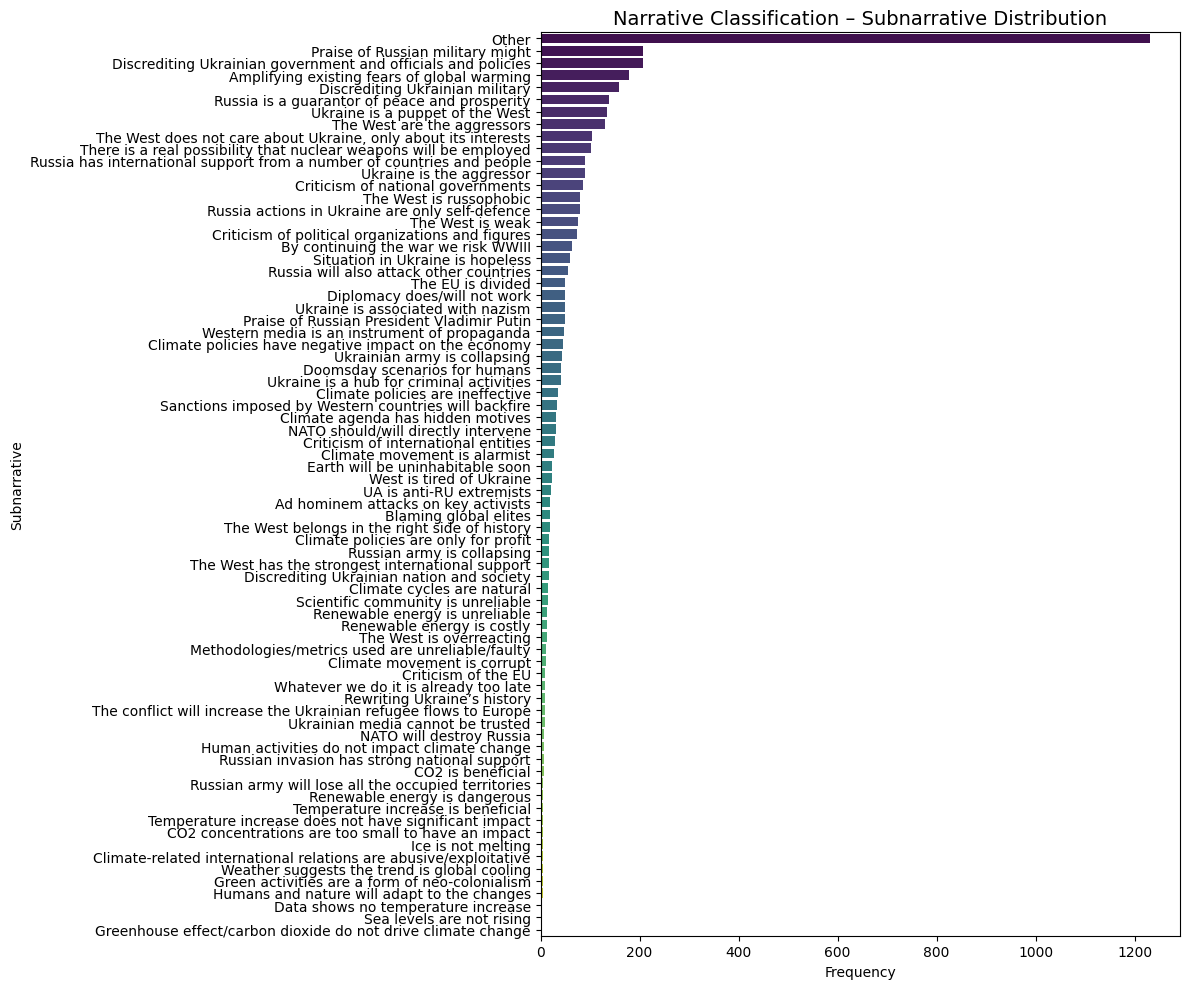

In [23]:

# Load the data
df = pd.read_csv("train-S2-labels.csv")

# Clean and explode subnarrative column
df = df[df['Subnarrative'].notna()].copy()
df['Subnarrative'] = df['Subnarrative'].astype(str).str.split(';')
df = df.explode('Subnarrative')
df['Subnarrative'] = df['Subnarrative'].str.strip()

# Extract domain, main narrative, and subnarrative label
extracted = df['Subnarrative'].str.extract(r'^(?P<Domain>[^:]+):\s*(?P<MainNarrative>[^:]+)(?::\s*(?P<SubnarrativeLabel>.*))?')
df = pd.concat([df, extracted], axis=1)

# Fill missing subnarratives (some only have 2 levels)
df['SubnarrativeLabel'] = df['SubnarrativeLabel'].fillna('Other')

# --- Plot Main Narrative Distribution ---
main_counts = df['MainNarrative'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=main_counts.values, y=main_counts.index, palette="magma")
plt.title("Narrative Classification – Main Narrative Distribution", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Main Narrative")
plt.tight_layout()
plt.show()

# --- Plot Subnarrative Distribution ---
sub_counts = df['SubnarrativeLabel'].value_counts()

plt.figure(figsize=(12, 10))
sns.barplot(x=sub_counts.values, y=sub_counts.index, palette="viridis")
plt.title("Narrative Classification – Subnarrative Distribution", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Subnarrative")
plt.tight_layout()
plt.show()


## Analysis 2: Distribution Shifts

### Input Shift

In [24]:
import nltk
nltk.download('punkt_tab')

# Download the punkt resource
def ensure_punkt():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

# Ensure punkt is available
ensure_punkt()

df = train_all_articles.copy()

stop_words = set(stopwords.words('english'))

# Extract CC and UA domain texts
cc_texts = df[df["Domain"] == "CC"]["Translated_Text"].dropna().tolist()
ua_texts = df[df["Domain"] == "UA"]["Translated_Text"].dropna().tolist()

# Tokenization and Preprocessing
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in stop_words]

cc_tokens = [preprocess(text) for text in cc_texts]
ua_tokens = [preprocess(text) for text in ua_texts]

# Flatten token lists
cc_flat = [word for sublist in cc_tokens for word in sublist]
ua_flat = [word for sublist in ua_tokens for word in sublist]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [25]:
### 1. Word Frequency Shift (Jensen-Shannon Divergence)
def compute_js_divergence(set1, set2):
    freq1 = Counter(set1)
    freq2 = Counter(set2)

    all_words = set(freq1.keys()).union(set(freq2.keys()))

    p = np.array([freq1.get(word, 1) for word in all_words], dtype=np.float32)
    q = np.array([freq2.get(word, 1) for word in all_words], dtype=np.float32)

    p = p / p.sum()
    q = q / q.sum()

    return jensenshannon(p, q)

js_divergence = compute_js_divergence(cc_flat, ua_flat)
print(f"Jensen-Shannon Divergence (Lexical Shift): {js_divergence:.4f}")


Jensen-Shannon Divergence (Lexical Shift): 0.4067


In [27]:
### 2. TF-IDF Keyword Comparison
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = vectorizer.fit_transform(cc_texts + ua_texts)

cc_tfidf = tfidf_matrix[:len(cc_texts)]
ua_tfidf = tfidf_matrix[len(cc_texts):]

feature_names = vectorizer.get_feature_names_out()

cc_mean_tfidf = np.mean(cc_tfidf.toarray(), axis=0)
ua_mean_tfidf = np.mean(ua_tfidf.toarray(), axis=0)

cc_top_words = [feature_names[i] for i in cc_mean_tfidf.argsort()[-10:]]
ua_top_words = [feature_names[i] for i in ua_mean_tfidf.argsort()[-10:]]

print("Top words in CC Domain:", cc_top_words)
print("Top words in UA Domain:", ua_top_words)


Top words in CC Domain: ['temperature', 'energy', 'emissions', 'world', 'heat', 'warming', 'temperatures', 'global', 'change', 'climate']
Top words in UA Domain: ['president', 'military', 'zelensky', 'nato', 'putin', 'war', 'ukrainian', 'russian', 'russia', 'ukraine']


In [29]:
### 3. Sentence Embedding Shift (Cosine Distance)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

cc_mean_embedding = np.mean(cc_embeddings, axis=0)
ua_mean_embedding = np.mean(ua_embeddings, axis=0)

cosine_dist = cosine(cc_mean_embedding, ua_mean_embedding)
print(f"Cosine Distance (Sentence Embedding Shift): {cosine_dist:.4f}")


NameError: name 'init_empty_weights' is not defined

In [33]:
### Chi-Squared Test for Lexical Frequency Shift
def compute_chi_squared(set1, set2):
    freq1 = Counter(set1)
    freq2 = Counter(set2)

    all_words = list(set(freq1.keys()).union(set(freq2.keys())))

    f1 = np.array([freq1.get(word, 1) for word in all_words])
    f2 = np.array([freq2.get(word, 1) for word in all_words])

    contingency_table = np.array([f1, f2])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    return chi2_stat, p_value

chi2_stat, p_value = compute_chi_squared(cc_flat, ua_flat)
print(f"Chi-Squared Statistic (Lexical Shift): {chi2_stat:.4f}")
print(f"P-Value (Lexical Shift): {p_value:.4f}")

Chi-Squared Statistic (Lexical Shift): 113156.5071
P-Value (Lexical Shift): 0.0000


In [34]:
### Maximum Mean Discrepancy (MMD) for Sentence Embedding Shift
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Encode sentences into embeddings
cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

# Compute MMD using Radial Basis Function (RBF) Kernel
def compute_mmd(X, Y, kernel='rbf'):
    def rbf_kernel(x, y, sigma=1.0):
        return np.exp(-norm(x - y) ** 2 / (2 * sigma ** 2))

    XX = np.mean([rbf_kernel(x, y) for x in X for y in X])
    YY = np.mean([rbf_kernel(x, y) for x in Y for y in Y])
    XY = np.mean([rbf_kernel(x, y) for x in X for y in Y])

    return XX + YY - 2 * XY

mmd_score = compute_mmd(cc_embeddings, ua_embeddings)
print(f"Maximum Mean Discrepancy (MMD) Score: {mmd_score:.4f}")


Maximum Mean Discrepancy (MMD) Score: 0.2002


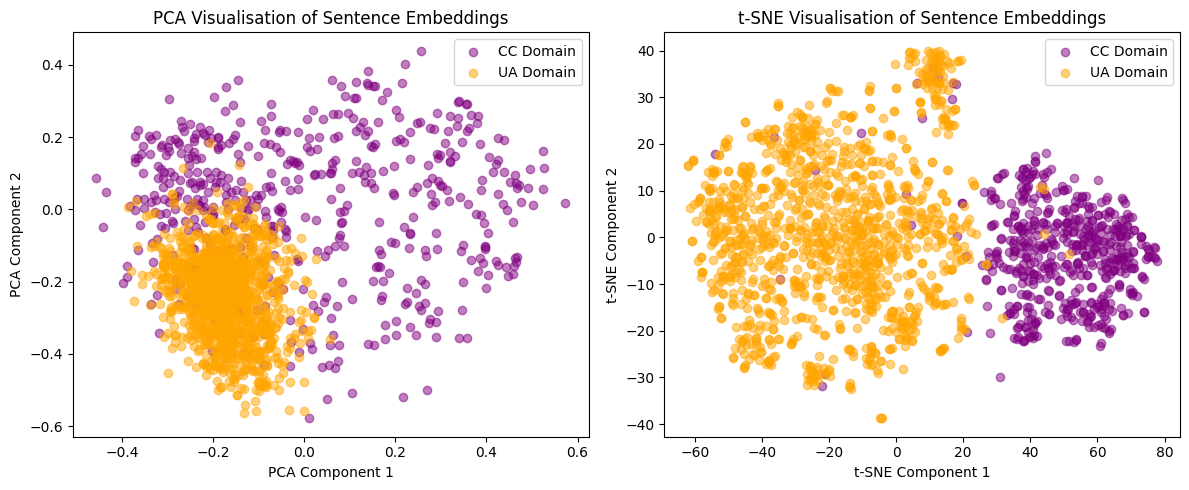

In [35]:
# Load Sentence-Transformer Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Encode sentences into embeddings
cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

### Principal Component Analysis
pca = PCA(n_components=2)
cc_pca = pca.fit_transform(cc_embeddings)
ua_pca = pca.transform(ua_embeddings)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(cc_pca[:, 0], cc_pca[:, 1], color='purple', alpha=0.5, label='CC Domain')
plt.scatter(ua_pca[:, 0], ua_pca[:, 1], color='orange', alpha=0.5, label='UA Domain')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualisation of Sentence Embeddings")
plt.legend()

### T-Distributed Stochastic Neighbour Embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
all_embeddings = np.vstack((cc_embeddings, ua_embeddings))
tsne_results = tsne.fit_transform(all_embeddings)

cc_tsne = tsne_results[:len(cc_embeddings)]
ua_tsne = tsne_results[len(cc_embeddings):]

plt.subplot(1, 2, 2)
plt.scatter(cc_tsne[:, 0], cc_tsne[:, 1], color='purple', alpha=0.5, label='CC Domain')
plt.scatter(ua_tsne[:, 0], ua_tsne[:, 1], color='orange', alpha=0.5, label='UA Domain')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualisation of Sentence Embeddings")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


### Label Shifts

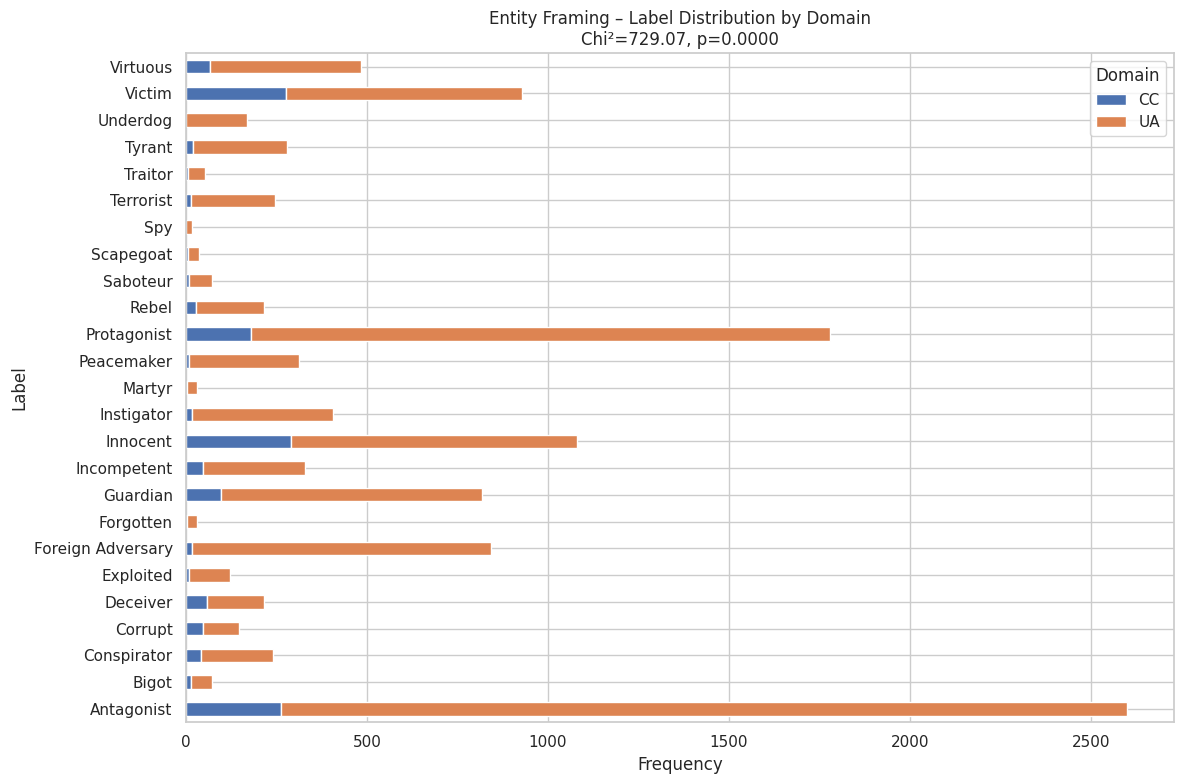

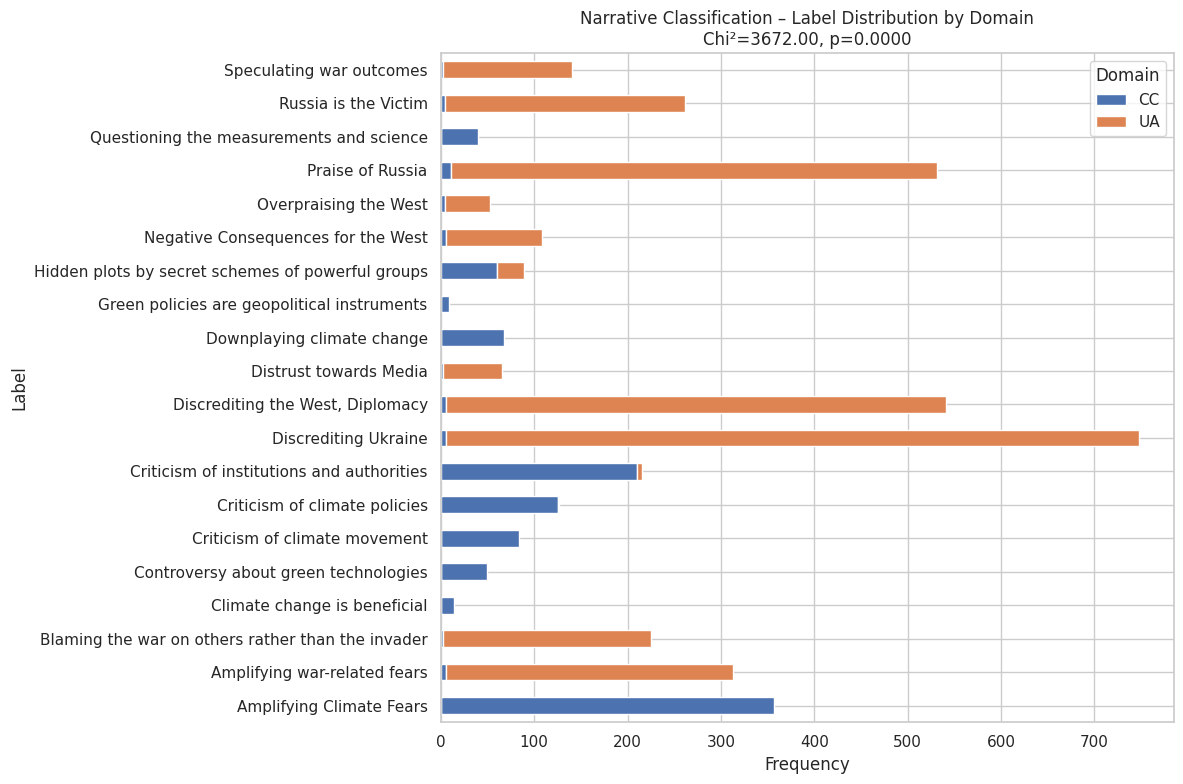

(3672.0027362008573, 0.0)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set(style="whitegrid")

# ---------- Load Data ----------
# Main article metadata (includes Domain info)
article_meta = pd.read_csv("train-all-articles.csv")[['Filename', 'Domain']]

# Subtask 1: Entity Framing
ef_df = pd.read_csv("train-S1-labels.csv")
ef_df = ef_df.merge(article_meta, on="Filename", how="left")

# Subtask 2: Narrative Classification
nc_df = pd.read_csv("train-S2-labels.csv")
nc_df = nc_df.merge(article_meta, on="Filename", how="left")

# ---------- Label Shift Function ----------
def compute_label_shift(df, label_col, domain_col='Domain', task_name='Task'):
    label_counts = pd.crosstab(df[label_col], df[domain_col]).fillna(0)

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(label_counts)

    # Plot
    label_counts.plot(kind='barh', stacked=True, figsize=(12, 8))
    plt.title(f"{task_name} – Label Distribution by Domain\nChi²={chi2:.2f}, p={p:.4f}")
    plt.xlabel("Frequency")
    plt.ylabel("Label")
    plt.tight_layout()
    plt.show()

    return chi2, p

# ---------- Entity Framing Processing ----------
ef_df = ef_df[ef_df['Label'].notna()].copy()
ef_df['Label'] = ef_df['Label'].astype(str).str.split(',\s*', regex=True)
ef_df = ef_df.explode('Label')
ef_df['Label'] = ef_df['Label'].str.strip().str.title()
ef_df = ef_df[ef_df['Label'].str.lower() != 'nan']

# Run shift analysis
compute_label_shift(ef_df, label_col='Label', domain_col='Domain', task_name='Entity Framing')

# ---------- Narrative Classification Processing ----------
nc_df = nc_df[nc_df['Subnarrative'].notna()].copy()
nc_df['Subnarrative'] = nc_df['Subnarrative'].astype(str).str.split(';')
nc_df = nc_df.explode('Subnarrative')
nc_df['Subnarrative'] = nc_df['Subnarrative'].str.strip()

# Extract main narrative
extracted = nc_df['Subnarrative'].str.extract(r'^(?P<DomainPrefix>[^:]+):\s*(?P<MainNarrative>[^:]+)')
nc_df = pd.concat([nc_df, extracted], axis=1)

# Run shift analysis
compute_label_shift(nc_df, label_col='MainNarrative', domain_col='Domain', task_name='Narrative Classification')


### Normalised plots

In [49]:
def compute_normalised_label_shift(df, label_col, domain_col='Domain', task_name='Task'):
    # Compute counts
    counts = pd.crosstab(df[label_col], df[domain_col]).fillna(0)

    # Normalize to percentage per column (domain)
    normalized = counts.div(counts.sum(axis=0), axis=1) * 100

    # Chi-squared test still on raw counts
    chi2, p, dof, expected = chi2_contingency(counts)

    # Plot normalised distributions
    normalized.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='Set2')
    plt.title(f"{task_name} – Normalised Label Distribution by Domain (%)\nChi²={chi2:.2f}, p={p:.4f}")
    plt.xlabel("Percentage of Domain")
    plt.ylabel("Label")
    plt.legend(title="Domain", loc='upper right')
    plt.tight_layout()
    plt.show()

    return chi2, p


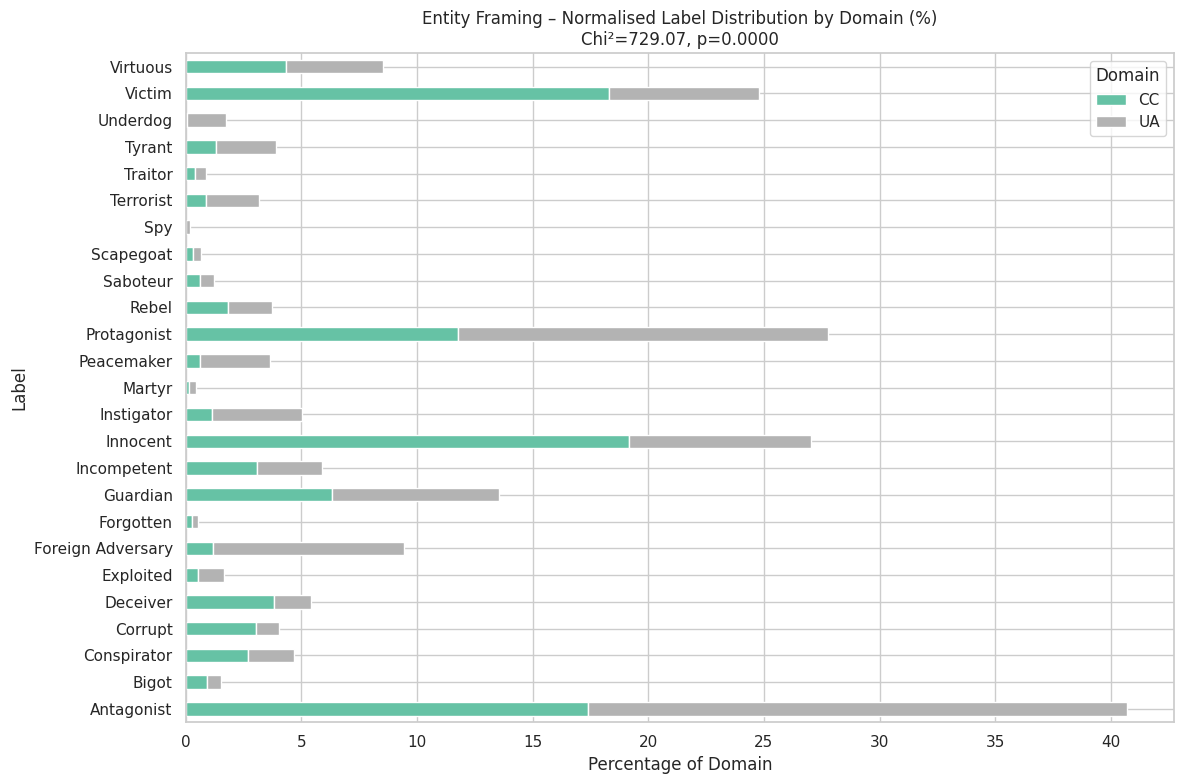

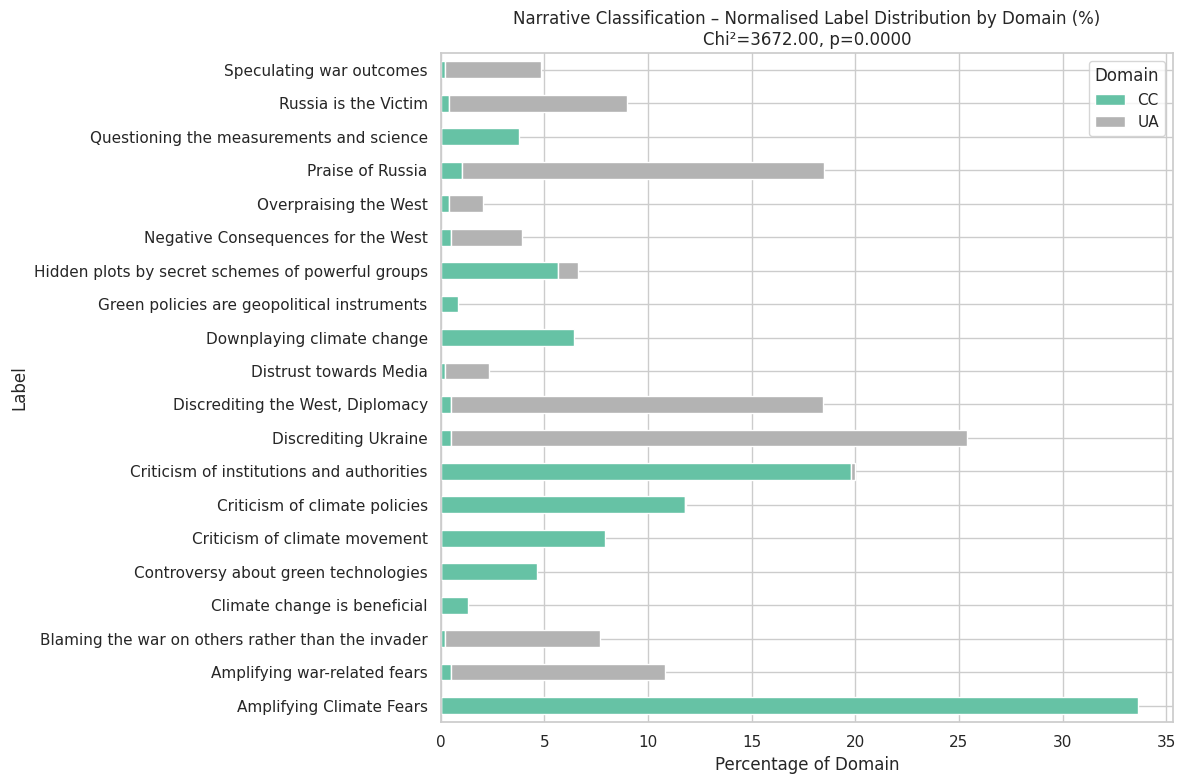

(3672.0027362008573, 0.0)

In [51]:
compute_normalised_label_shift(ef_df, label_col='Label', domain_col='Domain', task_name='Entity Framing')
compute_normalised_label_shift(nc_df, label_col='MainNarrative', domain_col='Domain', task_name='Narrative Classification')


# Entity Framing - Baseline

In [53]:
# =============================
# 0. Imports and Config
# =============================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import gc
import os
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Config
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_PATH = "entity_framing_model.pt"



In [55]:
# =============================
# 1. Load and Prepare Data (Fixed)
# =============================

# Load files
articles = pd.read_csv("train-S1-articles.csv")
labels = pd.read_csv("train-S1-labels.csv")

# Define subrole → main role taxonomy
subrole_to_main = {
    "Guardian": "Protagonist", "Martyr": "Protagonist", "Peacemaker": "Protagonist",
    "Rebel": "Protagonist", "Underdog": "Protagonist", "Virtuous": "Protagonist",
    "Instigator": "Antagonist", "Conspirator": "Antagonist", "Tyrant": "Antagonist",
    "Foreign Adversary": "Antagonist", "Traitor": "Antagonist", "Spy": "Antagonist",
    "Saboteur": "Antagonist", "Corrupt": "Antagonist", "Incompetent": "Antagonist",
    "Terrorist": "Antagonist", "Deceiver": "Antagonist", "Bigot": "Antagonist",
    "Forgotten": "Innocent", "Exploited": "Innocent", "Victim": "Innocent",
    "Scapegoat": "Innocent"
}

# Clean and explode multi-labels
labels = labels.dropna(subset=["Label"])
labels["Label"] = labels["Label"].str.split(',\s*')
labels = labels.explode("Label")
labels["Label"] = labels["Label"].str.strip().str.title()

# Map to main roles
labels["Role"] = labels["Label"].map(subrole_to_main)

# Filter out labels not in taxonomy
labels = labels[labels["Role"].notna()]

# Merge with article text
df = labels.merge(articles, on="Filename", how="left")
df = df.dropna(subset=["Translated_Text"])

# Insert entity into text context
ENTITY_MARKER = "<ENTITY>"
df["combined_text"] = df.apply(lambda x: f"{ENTITY_MARKER} {x['Entity']} {ENTITY_MARKER} {x['Translated_Text']}", axis=1)

# Encode main roles
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Role"])
num_classes = len(label_encoder.classes_)


In [57]:

# =============================
# 2. Tokenization and Dataset
# =============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class EntityFramingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }


/root/venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [11]:

# =============================
# 3. Train/Val Split
# =============================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["combined_text"].tolist(), y, test_size=0.2, random_state=42
)

train_dataset = EntityFramingDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = EntityFramingDataset(val_texts, val_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [13]:
# =============================
# 4. Model Definition
# =============================
class EntityFramingClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        pooled = self.dropout(pooled)
        return self.classifier(pooled)

model = EntityFramingClassifier(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=EPOCHS * len(train_loader))
loss_fn = nn.CrossEntropyLoss()


In [15]:
# =============================
# 5. Training Loop with Early Stopping
# =============================
best_val_loss = float("inf")
early_stop_counter = 0
patience = 2

print("\n Training commences.\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break



 Training commences.

100%|██████████| 608/608 [09:52<00:00,  1.03it/s]
Epoch 1/5 | Train Loss: 0.9068 | Val Loss: 0.5822
Best model saved.
100%|██████████| 608/608 [09:52<00:00,  1.03it/s]
Epoch 2/5 | Train Loss: 0.5265 | Val Loss: 0.4943
Best model saved.
100%|██████████| 608/608 [09:52<00:00,  1.03it/s]
Epoch 3/5 | Train Loss: 0.3840 | Val Loss: 0.4867
Best model saved.
100%|██████████| 608/608 [09:52<00:00,  1.03it/s]
Epoch 4/5 | Train Loss: 0.2923 | Val Loss: 0.5412
100%|██████████| 608/608 [09:53<00:00,  1.03it/s]
Epoch 5/5 | Train Loss: 0.2222 | Val Loss: 0.5420
Early stopping triggered.


In [16]:

# =============================
# 6. Evaluation
# =============================
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        true.extend(labels.cpu().numpy())

print("\n Evaluation on Validation Set:")
print(f"Accuracy: {accuracy_score(true, preds):.4f}")
print(f"F1 (macro): {f1_score(true, preds, average='macro'):.4f}")
print(f"F1 (micro): {f1_score(true, preds, average='micro'):.4f}")
print("\n Classification Report:")
print(classification_report(true, preds, target_names=label_encoder.classes_))




 Evaluation on Validation Set:
Accuracy: 0.8239
F1 (macro): 0.8099
F1 (micro): 0.8239

 Classification Report:
              precision    recall  f1-score   support

  Antagonist       0.87      0.85      0.86       576
    Innocent       0.77      0.75      0.76       234
 Protagonist       0.79      0.83      0.81       405

    accuracy                           0.82      1215
   macro avg       0.81      0.81      0.81      1215
weighted avg       0.82      0.82      0.82      1215



In [37]:
# =============================
# 7. Clear Memory
# =============================
torch.cuda.empty_cache()
gc.collect()

25762

# Narrative Classification - Baseline

In [59]:
# =============================
# config
# =============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
MODEL_PATH = "best_model.pt"


In [61]:
# =============================
# Load and Prepare Data
# =============================

df = train_all_articles.merge(train_S2_labels, on="Filename")
df = df.dropna(subset=["Translated_Text", "Narrative"])
df["Narrative"] = df["Narrative"].apply(lambda x: [n.strip() for n in str(x).split(";")])

# Multi-label binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["Narrative"])
num_classes = len(mlb.classes_)


In [63]:
# =============================
# Tokenisation and Dataset
# =============================
from transformers import DebertaV2Tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

def chunk_text(text, tokenizer, max_len):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i + max_len] for i in range(0, len(tokens), max_len)]
    return chunks

class MultiLabelNarrativeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        words = text.split()
        chunks = [" ".join(words[i:i + self.max_len]) for i in range(0, len(words), self.max_len)]

        input_ids, attention_masks = [], []
        for chunk in chunks:
            encoded = tokenizer.encode_plus(
                chunk,
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            input_ids.append(encoded["input_ids"])
            attention_masks.append(encoded["attention_mask"])

        return {
            "input_ids": torch.cat(input_ids),
            "attention_mask": torch.cat(attention_masks),
            "labels": torch.tensor(label, dtype=torch.float)
        }


In [65]:
# =============================
# Train-Validation Split
# =============================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Translated_Text"].tolist(), y, test_size=0.2, random_state=42
)

train_dataset = MultiLabelNarrativeDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = MultiLabelNarrativeDataset(val_texts, val_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch size 1 due to varying chunk count
val_loader = DataLoader(val_dataset, batch_size=1)


In [67]:
# =============================
# Model Definition
# =============================
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, num_chunks, seq_len = input_ids.size()
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        pooled = pooled.view(batch_size, num_chunks, -1).mean(1)
        return self.classifier(pooled)

model = MultiLabelClassifier(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=EPOCHS * len(train_loader))
loss_fn = nn.BCEWithLogitsLoss()

In [69]:
# =============================
# 5. Training Loop with Early Stopping
# =============================
best_val_loss = float("inf")
early_stop_counter = 0
patience = 2

print("\n Training commences...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].squeeze(0).to(device)
        attention_mask = batch["attention_mask"].squeeze(0).to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break


 Training commences...

100%|██████████| 1531/1531 [05:30<00:00,  4.63it/s]
Epoch 1/5 | Train Loss: 0.2365 | Val Loss: 0.2023
Best model saved.
100%|██████████| 1531/1531 [05:30<00:00,  4.63it/s]
Epoch 2/5 | Train Loss: 0.1974 | Val Loss: 0.1786
Best model saved.
100%|██████████| 1531/1531 [05:30<00:00,  4.63it/s]
Epoch 3/5 | Train Loss: 0.1842 | Val Loss: 0.1785
Best model saved.
100%|██████████| 1531/1531 [05:30<00:00,  4.63it/s]
Epoch 4/5 | Train Loss: 0.1711 | Val Loss: 0.1658
Best model saved.
100%|██████████| 1531/1531 [05:30<00:00,  4.63it/s]
Epoch 5/5 | Train Loss: 0.1605 | Val Loss: 0.1657
Best model saved.


In [104]:

# =============================
# 6. Evaluation
# =============================
def get_predictions_and_labels(dataloader, model, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

model.load_state_dict(torch.load(MODEL_PATH))
y_pred, y_true = get_predictions_and_labels(val_loader, model)

print("\n Evaluation Metrics on Validation Set:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score (Micro):  {f1_score(y_true, y_pred, average='micro'):.4f}")
print(f"F1 Score (Macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, average='micro'):.4f}")

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))




 Evaluation Metrics on Validation Set:
Accuracy:  0.3342
F1 Score (Micro):  0.5343
F1 Score (Macro):  0.2645
Precision: 0.7385
Recall:    0.4186

 Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.91      0.93      0.92        54
                      CC: Climate change is beneficial       0.00      0.00      0.00         2
              CC: Controversy about green technologies       0.00      0.00      0.00         7
                     CC: Criticism of climate movement       1.00      0.15      0.27        13
                     CC: Criticism of climate policies       0.42      0.36      0.38        14
         CC: Criticism of institutions and authorities       0.52      0.60      0.56        25
                        CC: Downplaying climate change       1.00      0.17      0.29         6
       CC: Green policies are geopolitical instruments      

In [3]:
# =============================
# 7. Clear Memory
# =============================
torch.cuda.empty_cache()
gc.collect()

435

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=49d39932-ba1f-4621-a036-ab99ade88496' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>